##### Preparando o ambiente

In [1]:
# Importando as bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carrega um modelo para tarefas de processamento e classificação de texto

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
# Importando o arquivo com os filmes
df_filmes = pd.read_csv('movies_metadata.csv', on_bad_lines='skip', low_memory = False)

# Visualizando cabeçalho do arquivo com infos dos filmes
df_filmes.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
# Importando o arquivo de avaliações
df_avaliacoes = pd.read_csv('ratings.csv')

# Visualizando cabeçalho do arquivo com as avaliações
df_avaliacoes.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [5]:
# Importando o arquivo com os identificadores
df_links = pd.read_csv('links.csv')

# Visualizando cabeçalho do arquivo com infos dos identificadores
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
# Importando o arquivo com as palavras chaves
df_keywords = pd.read_csv('keywords.csv')

# Visualizando cabeçalho do arquivo com as palavras chaves
df_keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


##### Análise exploratória e preparação dos dados.

In [7]:
# Limpeza e tratamento dos dados da planilha de avaliações

df_avaliacoes.drop(['timestamp'], axis=1, inplace=True) # Exclui coluna que não será usada
df_avaliacoes['movieId'] = df_avaliacoes['movieId'].astype(int, errors='ignore') # Transforma valores em datatype int

In [8]:
# Visualizando informações após tratamento

print(f'Valores únicos para cada coluna: \n{df_avaliacoes.apply(pd.Series.nunique)} \n')
print(f'Quantidade de {len(df_avaliacoes)} avaliações.\n')

Valores únicos para cada coluna: 
userId     270896
movieId     45115
rating         10
dtype: int64 

Quantidade de 26024289 avaliações.



In [9]:
# Visualizando df_avaliações após tratamento anterior

df_avaliacoes.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [10]:
# Visão sobre média das avaliações

df_avaliacoes_media = df_avaliacoes['rating'].mean()
print(f'Valor médio das avaliações é de {df_avaliacoes_media:.2f}')

Valor médio das avaliações é de 3.53


<Axes: title={'center': 'Frequência das avaliações'}, ylabel='Frequency'>

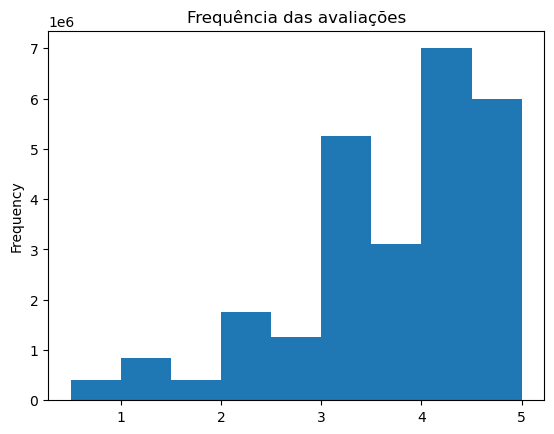

In [11]:
# Plota histograma para demonstrar a frequência das avaliações

df_avaliacoes['rating'].plot(kind='hist', bins=9, title='Frequência das avaliações')

O Dataset df_avaliacoes, possui 26M de avaliações de 270K usuários. A média das avaliações é de 3.53, porém é possível observar pelo histograma que os usuários costumam atribuir notas que vão de 4 a 5.

Na próxima etapa, é preciso combinar os outros datasets. Importante ressaltar que a coluna "id" em df_filmes e df_keywords não é "movie_id", mas "tmdbId".

In [12]:
# Limpeza e tratamento dos dados da planilha de metadados

df_filmes.rename(columns={'id': 'tmdbId'}, inplace=True) # Renomeia a coluna "id" para "tmdbId"

df_filmes["tmdbId"] =pd.to_numeric(df_filmes['tmdbId'], errors='coerce',downcast="integer") # Converte a coluna tmdbId para datatype numérico

In [13]:
# Limpeza e tratamento dos dados da planilha de identificadores

df_links = df_links[['movieId', 'tmdbId']] # Seleciona colunas que serão utilizadas
df_links.drop_duplicates(subset=['tmdbId'], inplace=True) # Exclui linhas duplicadas da coluna "tmdbId"

In [14]:
# Renomeia a coluna "id" para "tmdbId" em df_keywords

df_keywords.rename(columns={'id': 'tmdbId'}, inplace=True)

In [15]:
# Juntando os DataFrames df_links e df_filmes, em função da coluna "tmdbId", utilizando método inner join

df_filmes = pd.merge(df_links, df_filmes, how='inner', on='tmdbId')

In [16]:
# Converte em df_filmes, a coluna "movieId" para o datatype numérico

df_filmes["movieId"] =pd.to_numeric(df_filmes['movieId'], errors='coerce',downcast="integer")

In [17]:
# Exclui linhas com valores NaN

df_filmes.dropna(subset=["movieId"],inplace=True)

In [18]:
# Juntando os DataFrames df_filmes e df_keywords, em função da coluna "tmdbId", utilizando método left join

df_filmes = pd.merge(df_filmes, df_keywords, how='left', on='tmdbId')

In [19]:
# Visualizando novo dataframe

df_filmes.head()

,movieId,tmdbId,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,1,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,2,8844.0,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,3,15602.0,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,Grumpier Old Men,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,4,31357.0,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,5,11862.0,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,Father of the Bride Part II,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [20]:
# Filtrando colunas do dataframe df_filmes

df_filmes = df_filmes[['movieId', 'original_language', 'original_title', 'overview', 'revenue', 'runtime', 'keywords']]
df_filmes.head()     

,movieId,original_language,original_title,overview,revenue,runtime,keywords
0,1,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",373554033.0,81.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,2,en,Jumanji,When siblings Judy and Peter discover an encha...,262797249.0,104.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,3,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,0.0,101.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,4,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",81452156.0,127.0,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,5,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,76578911.0,106.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [21]:
# Juntando os DataFrames df_avaliacoes e df_filmes, em função da coluna "movieId", utilizando método inner join

df_avaliacoes_filmes = pd.merge(df_avaliacoes, df_filmes, on="movieId",how="inner")

In [22]:
# Vamos manter somente filmes que tem idioma original inglês

df_avaliacoes_filmes.drop(df_avaliacoes_filmes[df_avaliacoes_filmes['original_language'] != 'en'].index, inplace=True) 

In [23]:
# Considerar apenas usuários que votaram em mais de 100 filmes

user_groupby = pd.Series(Counter(df_avaliacoes_filmes['userId']))
votantes_freq = user_groupby.loc[lambda x : x > 100]
print(f'No total, foi considerado {votantes_freq.size} votantes, pois votaram em mais de 100 filmes.')

No total, foi considerado 60539 votantes, pois votaram em mais de 100 filmes.


In [24]:
# Considerar filmes como populares aqueles que tiveram mais de 1000 votos

movies_groupby = pd.Series(Counter(df_avaliacoes_filmes['movieId']))
filmes_populares = movies_groupby.loc[lambda x : x > 1000]
print(f'No total, foi considerado {filmes_populares.size} filmes como popular, pois eles tiveram mais de 1000 avaliações.')

No total, foi considerado 3476 filmes como popular, pois eles tiveram mais de 1000 avaliações.


In [25]:
# Converte em array numpy

votantes_freq = np.array(votantes_freq.index)
filmes_populares = np.array(filmes_populares.index)

In [26]:
# Mantém somente userId dos usuários considerados votantes frequentes

df_avaliacoes_filmes = df_avaliacoes_filmes[df_avaliacoes_filmes['userId'].isin(votantes_freq)]

In [27]:
# Mantém somente movieId dos filmes considerados populares

df_avaliacoes_filmes = df_avaliacoes_filmes[df_avaliacoes_filmes['movieId'].isin(filmes_populares)]

In [28]:
# Exclui linhas que contenham valores ausentes

df_avaliacoes_filmes.dropna(inplace=True)

In [29]:
# Visualizando informações sobre o dataframe

print(f'{df_avaliacoes_filmes.info()}\n')

<class 'pandas.core.frame.DataFrame'>
Index: 16550290 entries, 1 to 25344669
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   userId             int64  
 1   movieId            int32  
 2   rating             float64
 3   original_language  object 
 4   original_title     object 
 5   overview           object 
 6   revenue            float64
 7   runtime            float64
 8   keywords           object 
dtypes: float64(3), int32(1), int64(1), object(4)
memory usage: 1.2+ GB
None



##### Finalizamos a etapa de análise exploratória e preparação dos dados. Mesmo após finalizar, há mais de 16M de dados. A partir deste ponto, criamos o sistema de recomendação.

In [30]:
# Cria um novo DF para realizar a matriz

df_matrix =  df_avaliacoes_filmes[['userId', 'original_title', 'rating']]
df_matrix.head()

,userId,original_title,rating
1,11,Braveheart,3.5
3,24,Braveheart,5.0
5,30,Braveheart,5.0
7,34,Braveheart,5.0
8,49,Braveheart,4.0


In [31]:
# Cria um pivot - as linhas representam as avaliações dos usuários e as colunas representam os filmes

filmes_pivot = df_matrix.pivot_table(index='original_title',  columns='userId', values='rating')
filmes_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 60539 entries, 8 to 270896
dtypes: float64(60539)
memory usage: 1.5+ GB


In [32]:
# Substitui valores ausentes por 0

filmes_pivot = filmes_pivot.apply(lambda row: row.fillna(0), axis=1)
filmes_pivot.head()

userId,8,11,12,15,16,20,24,30,34,37,...,270859,270869,270871,270872,270879,270885,270887,270893,270894,270896
original_title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
*batteries not included,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Cloverfield Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
10 Things I Hate About You,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Vamos utilizar o método KNN
Através dele, queremos analisar os vizinhos mais próximos buscando por similaridade. Foi testado utilizando distância euclidiana e cosseno, onde a métrica de similaridade cosseno funcionou melhor.

In [33]:
# Criando e treinando o modelo preditivo KNN

modelo = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=2)
modelo.fit(filmes_pivot)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=2, n_neighbors=20)

Feito o modelo vamos afinar a recomendação ao criar a função 'recomendacao'

##### Criando a função 'recomendacao'
Vamos aprimorar a recomendação ao utilizar dados de sinopse e gênero dos filmes, para aumentar a similaridade entre os filmes utilizado como referência e os sugeridos.

Utilizamos a biblioteca SentenceTransformer, que carrega modelos pré-treinados de sentenças. Com essas sentenças, irá gerar vetores que usaremos como referencia ao calcular a similaridade.

Utilizamos o dataset df_filmes para criar os vetores a partir das frases da sinopse e para combinar as tags de "keywords", criando uma string.

In [34]:
# Função que recomenda filmes conforme modelo treinado e se atender as características de overview e keywords

def recomendacao(nome_filme, modelo, sparse):
  lista_recomendacao = [nome_filme] #Lista com o filme de referencia
  distancia_geral = [1] #Lista de distancia
  try:
    
    #Busca filmes similares ao filme de referencia com knn
    
    dist, idx = modelo.kneighbors(sparse.loc[nome_filme].values.reshape(1,-1),n_neighbors=13)
    
    #Preenche com os filmes recomendados
    
    for i in range(1, len(dist.flatten())):
      nome_filme = sparse.index[idx.flatten()[i]]
      lista_recomendacao.append(nome_filme)
      distancia = dist.flatten()[i]
      distancia_geral.append(distancia)
  except:
    
    #Em caso de erro irá imprimir
    
    print(f'O filme {nome_filme} não está em nosso banco de dados.')

  overview_vet = []
  overview_similaridade = [] #Lista com infos de overview
  for filme in lista_recomendacao:
    overview = df_filmes[df_filmes['original_title'] == filme]['overview'].values[0]
    vet = model.encode(overview) #Utilizando "model" como parametro para codificar overview
    overview_vet.append(vet)
    
    #Calcula similaridade de overview
    
    cosine_scores = util.cos_sim(overview_vet[0], vet)
    overview_similaridade.append(cosine_scores.item())

  keyword_vet = []
  keyword_similaridade = [] #Lista com infos de palavras-chaves
  for filme in lista_recomendacao:
    
    #Extraindo palavras-chaves
    
    keywords = list(df_filmes[df_filmes['original_title'] == filme]['keywords'].values[0].split(","))
    tags = []
    for tag in keywords:
        
    # Processa palavras-chaves para encontrar tags 
    
      if tag.startswith(" 'name"):
        tags.append(tag[10:-2])
    tags[-1] = tags[-1][:-1]

    tags_comb = " ".join(tags)
    vet = model.encode(tags_comb) #Utilizando "model" como parametro para codificar keywords
    keyword_vet.append(vet)
    
    #Calcula similaridade das palavras-chaves
    
    cosine_scores = util.cos_sim(keyword_vet[0], vet)
    keyword_similaridade.append(cosine_scores.item())


  print(f'Considerando sua seleção de {lista_recomendacao[0]}, é recomendado que você assista: \n')
  counter = 1
  for i in range(1 , len(lista_recomendacao)):
    if overview_similaridade[i] > 0.2 and keyword_similaridade[i] > 0.28:
      print(f'{counter}- {lista_recomendacao[i]}, a distância (similaridade) é de {distancia_geral[i]:.3f}')
      counter += 1

##### Resultados
Não recomendamos filmes que tenham similaridade inferior a 0.2 em relação a overview e a 0.28 com as tags criadas através das palavras chaves.

Gostaríamos de ressaltar que a similaridade de cosseno vai de 0 a 1.0. Logo, consideramos pontuações acima de 0.4 bem altas.

In [35]:
recomendacao('The Matrix Reloaded', modelo, filmes_pivot)

Considerando sua seleção de The Matrix Reloaded, é recomendado que você assista: 

1- The Matrix Revolutions, a distância (similaridade) é de 0.223
2- The Matrix, a distância (similaridade) é de 0.361
3- Minority Report, a distância (similaridade) é de 0.361
4- Star Wars: Episode II - Attack of the Clones, a distância (similaridade) é de 0.379


In [36]:
recomendacao('Batman Begins', modelo, filmes_pivot)

Considerando sua seleção de Batman Begins, é recomendado que você assista: 

1- The Dark Knight, a distância (similaridade) é de 0.261
2- V for Vendetta, a distância (similaridade) é de 0.327
3- Iron Man, a distância (similaridade) é de 0.329
4- The Incredibles, a distância (similaridade) é de 0.336
5- Pirates of the Caribbean: The Curse of the Black Pearl, a distância (similaridade) é de 0.338
6- Sin City, a distância (similaridade) é de 0.345
7- Kill Bill: Vol. 1, a distância (similaridade) é de 0.355


In [37]:
recomendacao('2 Fast 2 Furious', modelo, filmes_pivot)

Considerando sua seleção de 2 Fast 2 Furious, é recomendado que você assista: 

1- The Fast and the Furious, a distância (similaridade) é de 0.480
2- The Fast and the Furious: Tokyo Drift, a distância (similaridade) é de 0.502
3- Fast & Furious, a distância (similaridade) é de 0.572
4- The Transporter, a distância (similaridade) é de 0.619
5- Fast Five, a distância (similaridade) é de 0.653


In [38]:
recomendacao('127 Hours', modelo, filmes_pivot)

Considerando sua seleção de 127 Hours, é recomendado que você assista: 

1- Inception, a distância (similaridade) é de 0.555
2- Drive, a distância (similaridade) é de 0.585
3- Into the Wild, a distância (similaridade) é de 0.590


In [39]:
recomendacao('Toy Story', modelo, filmes_pivot)

Considerando sua seleção de Toy Story, é recomendado que você assista: 

1- Toy Story 2, a distância (similaridade) é de 0.309
2- Aladdin, a distância (similaridade) é de 0.330


In [40]:
recomendacao('1408', modelo, filmes_pivot)

Considerando sua seleção de 1408, é recomendado que você assista: 

1- The Mist, a distância (similaridade) é de 0.576
2- 28 Weeks Later, a distância (similaridade) é de 0.612
3- 30 Days of Night, a distância (similaridade) é de 0.631
4- Drag Me to Hell, a distância (similaridade) é de 0.633
5- Paranormal Activity, a distância (similaridade) é de 0.645
6- The Number 23, a distância (similaridade) é de 0.656
7- Saw II, a distância (similaridade) é de 0.658
